# What Magic the Gathering Set's Draft Booster Pack Is Worth the Most?

The goal of this project is to compare and discover which Magic the Gathering set's draft booster pack is worth the most. The three sets I will be comparing are: Modern Horizons 2, Adventures in the Forgotten Realms, and Innistrad: Midnight Hunt. To do this, we will need to do three things; clean the data so it's usuable for our purposes, generate 216,000 packs from each set, and calculate the prices of each generated pack. Then we'll plot them in a nice box and whisker plot to display our findings.

In [1]:
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

First we need to import our data. I am utilizing *scryfall.com*'s bulk data download option. Currently, I have a JSON file containing every card object on Scryfall in every language. Something that's important to know is that Magic the Gathering card prices are very volatile. Card prices are updated every 12 hours and become stale after just 24. This data is from *04-07-22*, and is severely outdated.

In [2]:
# Load the dataframe
with open('card_data.json') as df:
    data = json.load(df)

Now we have a list of dictionaries where each dictionary is a single card. While I won't go into the specifics of how the dataframe is compiled, as there are a lot of keys, more information can be found at https://scryfall.com/docs/api.

## Cleaning the Data

First we compile every card from a specific set into a list.

In [3]:
# Compile cards into a list by given set name and other parameters
def make_set_list(set_name):
    set_list = []
    for card in data:
        # Add the card to the list if it's from the given set, is in english, and is not borderless
        if card["set"] == set_name and card["booster"] == True and card["lang"] == "en" and card["border_color"] != "borderless":
            set_list.append(card)
            
    return set_list

In [4]:
# Print a single card
set_list = make_set_list("mh2")
print(set_list[0])

{'object': 'card', 'id': '0013a9c4-77a1-418d-85c2-bd68b65cd3d4', 'oracle_id': '335b5302-2272-405a-b2b8-3943b3df335f', 'multiverse_ids': [522268], 'mtgo_id': 90761, 'tcgplayer_id': 239404, 'cardmarket_id': 565719, 'name': 'Dakkon, Shadow Slayer', 'lang': 'en', 'released_at': '2021-06-18', 'uri': 'https://api.scryfall.com/cards/0013a9c4-77a1-418d-85c2-bd68b65cd3d4', 'scryfall_uri': 'https://scryfall.com/card/mh2/192/dakkon-shadow-slayer?utm_source=api', 'layout': 'normal', 'highres_image': True, 'image_status': 'highres_scan', 'image_uris': {'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/0/0/0013a9c4-77a1-418d-85c2-bd68b65cd3d4.jpg?1626098233', 'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/0/0/0013a9c4-77a1-418d-85c2-bd68b65cd3d4.jpg?1626098233', 'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/0/0/0013a9c4-77a1-418d-85c2-bd68b65cd3d4.jpg?1626098233', 'png': 'https://c1.scryfall.com/file/scryfall-cards/png/front/0/0/0013a9c4-77a1-

A lot of the descriptors here are unneeded for what we're trying to accomplish. What we'll do is recreate each card, only using the info we need.

We need:
* The card's name
* The set it's from
* The card's rarity
* Both the normal price, and the foil price
* The card's id
* The card's type line
* If the card is foil (Default false)
* If the card can be foil

In [5]:
# Selects the important info we need from the cards and puts them back into a list
def clean_set(set_list):
    clean_set_list = []
    clean_dict = {}
    for card in set_list:
        clean_dict["name"] = card["name"]
        
        clean_dict["set"] = card["set"]
    
        clean_dict["rarity"] = card["rarity"]
            
        clean_dict["usd"] = card["prices"]["usd"]
        
        clean_dict["usd_foil"] = card["prices"]["usd_foil"]
            
        clean_dict["id"] = card["id"]
        
        clean_dict["type"] = card["type_line"]
        
        clean_dict["foil_bool"] = False
        
        clean_dict["foil"] = card["foil"]
            
        clean_set_list.append(clean_dict)
        clean_dict = {}
    
    return clean_set_list

Now that our cards are cleaned, we can start generating packs. But what is inside a Magic the Gathering pack?

## Making Packs

Each set has different card requirements for their respective packs.
Generally, a pack will contain 15 cards, one of which can have a foil finish.

In [47]:
cache = {}

Starting with Modern Horizons 2, I found the requirements [here](https://magic.wizards.com/en/articles/archive/feature/collecting-modern-horizons-2-2021-05-21).

* 10 Commons
* 3 Uncommons
* 1 Rare or Mythic Rare
* 1 New to modern reprint (A special list of cards that could fit in this slot)
* (1 in 3 chance of any card being foil)

In [28]:
# Generate a list of cards you would find in a Modern Horizons 2 pack
def make_mh2_pack(cleaned_set):
    pack = []
    # Card names that are specific to the set
    new_to_modern = ["Zuran Orb", "Yavimaya Elder", "Wonder", "Vindicate", "Upheaval", "Titania, Protector of Argoth", "Sterling Grove", "Squirrel Mob", "Soul Snare", "Solitary Confinement", "Skirge Familiar", "Shardless Agent", "Seal of Removal", "Seal of Cleansing", "Sea Drake", "Sanctum Prelate", "Riptide Laboratory", "Quirion Ranger", "Patriarch's Bidding", "Patchwork Gnomes", "Nevinyrral's Disk", "Mogg Salvage", "Mishra's Factory", "Mirari's Wake", "Millikin", "Karmic Guide", "Imperial Recruiter", "Hunting Pack", "Greed", "Gorilla Shaman", "Goblin Bombardment", "Flame Rift", "Fire // Ice", "Extruder", "Enchantress's Presence", "Cursed Totem", "Counterspell", "Chance Encounter", "Chainer, Nightmare Adept", "Cabal Coffers", "Braids, Cabal Minion", "Bone Shredder", "Angelic Curator"]
    
    # Sort cards by rarity and store them in the cache
    if "mh2_commons" not in cache:
        commons = []
        for card in cleaned_set:
            if card["rarity"] == "common" and "Basic" not in card["type"].split(" "):
                commons.append(card)
        cache["mh2_commons"] = commons
        
    if "mh2_uncommons" not in cache:
        uncommons = []
        for card in cleaned_set:
            if card["rarity"] == "uncommon":
                uncommons.append(card)
        cache["mh2_uncommons"] = uncommons
        
    if "mh2_rares" not in cache:
        rares = []
        for card in cleaned_set:
            if card["rarity"] == "rare":
                rares.append(card)
        cache["mh2_rares"] = rares
        
    if "mh2_mythics" not in cache:
        mythics = []
        for card in cleaned_set:
            if card["rarity"] == "mythic":
                mythics.append(card)
        cache["mh2_mythics"] = mythics
        
    if "new_to_moderns" not in cache:
        new_to_moderns = []
        for card in cleaned_set:
            if card["name"] in new_to_modern:
                new_to_moderns.append(card)
        cache["new_to_moderns"] = new_to_moderns

    # 10 commons
    for i in range(10):
        pack.append(random.choice(cache["mh2_commons"]))
        
    # 3 uncommons
    for i in range(3):
        pack.append(random.choice(cache["mh2_uncommons"]))
        
    # 1 rare/mythic (1 in 7.4 mythic)
    if (random.random()*100) <= 13.51:
        pack.append(random.choice(cache["mh2_mythics"]))
    else:
        pack.append(random.choice(cache["mh2_rares"]))
    
    # 1 new to modern reprint
    pack.append(random.choice(cache["new_to_moderns"]))
    
    # Add foils
    if random.random()*100 < 33.34:
        index = random.randint(0, 14)
        new_foil = pack[index].copy()
        new_foil["foil_bool"] = True
        pack[index] = new_foil
    
    return pack

Next is [Adventures In the Forgotten Realms](https://magic.wizards.com/en/articles/archive/feature/adventures-forgotten-realms-product-overview-2021-06-29).

* 10 Commons
* 3 Uncommons
* 1 Rare or Mythic Rare
* 1 Basic Land
* (1 in 3 chance of any common being foil)

In [46]:
# Generate a list of cards you would find in an Adventures In the Forgotten Realms pack
def make_afr_pack(cleaned_set):
    pack = []
    
    # Sort cards by rarity
    if "afr_commons" not in cache:
        commons = []
        for card in cleaned_set:
            if card["rarity"] == "common" and "Basic" not in card["type"].split(" "):
                commons.append(card)
        cache["afr_commons"] = commons
        
    if "afr_uncommons" not in cache:
        uncommons = []
        for card in cleaned_set:
            if card["rarity"] == "uncommon":
                uncommons.append(card)
        cache["afr_uncommons"] = uncommons
        
    if "afr_rares" not in cache:
        rares = []
        for card in cleaned_set:
            if card["rarity"] == "rare":
                rares.append(card)
        cache["afr_rares"] = rares
        
    if "afr_mythics" not in cache:
        mythics = []
        for card in cleaned_set:
            if card["rarity"] == "mythic":
                mythics.append(card)
        cache["afr_mythics"] = mythics
        
    if "afr_basics" not in cache:
        basics = []
        for card in cleaned_set:
            if "Basic" in card["type"].split(" "):
                basics.append(card)
        cache["afr_basics"] = basics
        
    # 10 commons
    for i in range(10):
        pack.append(random.choice(cache["afr_commons"]))
        
    # 3 uncommons    
    for i in range(3):
        pack.append(random.choice(cache["afr_uncommons"]))
        
    # 1 rare/mythic (1 in 7.4 mythic)   
    if (random.random()*100) <= 13.51:
        pack.append(random.choice(cache["afr_mythics"]))
    else:
        pack.append(random.choice(cache["afr_rares"]))
            
    # 1 basic land
    pack.append(random.choice(cache["afr_basics"]))
    
    # Add foils
    if random.random()*100 < 33.34:
        index = random.randint(0, 14)
        new_foil = pack[index].copy()
        new_foil["foil_bool"] = True
        pack[index] = new_foil
        
    return pack

Lastly, [Innistrad: Midnight Hunt](https://magic.wizards.com/en/articles/archive/feature/boosters-and-products-innistrad-midnight-hunt-2021-09-02).

* 10 Commons
* 3 Uncommons
* 1 Rare or Mythic Rare
* 1 Basic Land
* (1 in 3 chance of any card being foil)

In [45]:
# Generate a list of cards you would find in an Innistrad: Midnight Hunt pack
def make_mid_pack(cleaned_set):
    pack = []
    
        # Sort cards by rarity
    if "mid_commons" not in cache:
        commons = []
        for card in cleaned_set:
            if card["rarity"] == "common" and "Basic" not in card["type"].split(" "):
                commons.append(card)
        cache["mid_commons"] = commons
        
    if "mid_uncommons" not in cache:
        uncommons = []
        for card in cleaned_set:
            if card["rarity"] == "uncommon":
                uncommons.append(card)
        cache["mid_uncommons"] = uncommons
        
    if "mid_rares" not in cache:
        rares = []
        for card in cleaned_set:
            if card["rarity"] == "rare":
                rares.append(card)
        cache["mid_rares"] = rares
        
    if "mid_mythics" not in cache:
        mythics = []
        for card in cleaned_set:
            if card["rarity"] == "mythic":
                mythics.append(card)
        cache["mid_mythics"] = mythics
        
    if "mid_basics" not in cache:
        basics = []
        for card in cleaned_set:
            if "Basic" in card["type"].split(" "):
                basics.append(card)
        cache["mid_basics"] = basics
    
    # 10 commons
    for i in range(10):
        pack.append(random.choice(cache["mid_commons"]))
        
    # 3 uncommons    
    for i in range(3):
        pack.append(random.choice(cache["mid_uncommons"]))
        
    # 1 rare/mythic (1 in 7.4 mythic)    
    if (random.random()*100) <= 13.51:
        pack.append(random.choice(cache["mid_mythics"]))
    else:
        pack.append(random.choice(cache["mid_rares"]))
            
    # 1 basic land
    pack.append(random.choice(cache["mid_basics"]))
        
    # Add foils
    if random.random()*100 < 33.34:
        index = random.randint(0, 14)
        new_foil = pack[index].copy()
        new_foil["foil_bool"] = True
        pack[index] = new_foil
        
    return pack

Next, we'll generate 216,000 packs. This number will be significant later.

In [31]:
# Generate 216000 packs of the given set
def make_pack_list(set_clean):
    list_packs = []
    if set_clean[0]["set"] == "mh2":
        for i in range(216000):
            pack = make_mh2_pack(set_clean)
            
            list_packs.append(pack)
            
    if set_clean[0]["set"] == "afr":
        for i in range(216000):
            pack = make_afr_pack(set_clean)
            
            list_packs.append(pack)
            
    if set_clean[0]["set"] == "mid":
        for i in range(216000):
            pack = make_mid_pack(set_clean)
    
            list_packs.append(pack)
        
    return list_packs

This function consolodates everything we've done into one easy step.

In [10]:
# Makes, cleans, and generates a list of 216000 packs of the given set
def get_packs(set_name):
    packs = make_pack_list(clean_set(make_set_list(set_name)))
    
    return packs

Generating. . .

In [48]:
mh2_packs = get_packs("mh2")

In [49]:
afr_packs = get_packs("afr")

In [50]:
mid_packs = get_packs("mid")

## Pricing

Now that we've generated the packs, it's time to price them. Making sure to take into account foil pricing, we'll use a short function to accumulate a single price for a given pack.

In [51]:
# Prices a given pack
def get_pack_price(pack):
    pack_price = 0.0
    for card in pack:
        # Checks for foil
        if card["foil_bool"] == True and card["usd_foil"] != None:
            pack_price += float(card["usd_foil"])
        else:
            pack_price += float(card["usd"])
        
    return pack_price

Another function to make pricing every pack easier.

In [52]:
# Prices any number of packs
def price_set_packs(set_packs):
    set_packs_prices = []
    
    for pack in set_packs:
        pack_price = get_pack_price(pack)
    
        set_packs_prices.append(pack_price)

    return set_packs_prices

Calculating prices. . .

In [53]:
mh2_prices = price_set_packs(mh2_packs)
afr_prices = price_set_packs(afr_packs)
mid_prices = price_set_packs(mid_packs)

In [73]:
print("Average Mh2 pack value: ", sum(mh2_prices)/len(mh2_prices))
print("Average Afr pack value: ", sum(afr_prices)/len(afr_prices))
print("Average Mid pack value: ", sum(mid_prices)/len(mid_prices))

Average Mh2 pack value:  6.215305046296397
Average Afr pack value:  2.9914581481480647
Average Mid pack value:  2.9485598148148084


Now to visualize our profits.

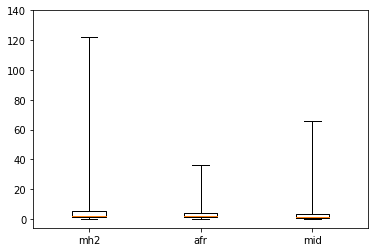

In [55]:
# Box and whisker plot of pack prices
plt.boxplot([mh2_prices, afr_prices, mid_prices], whis=(0,100), labels=["mh2", "afr", "mid"])
plt.yticks(ticks=[0, 20, 40, 60, 80, 100, 120, 140])
plt.show()

The price to buy a pack is, in order:
* 7.59 usd
* 2.97 usd
* 3.39 usd

Average selling price:
* 6.96 usd
* 3.38 usd
* 4.21 usd

For Modern Horizons 2, the average is well below the buying price of an unopened pack, but the maximum price is way up around 120 usd. The other two sets have a relatively large gap for the better between their average selling price and their pack cost.

## Real Pack Prices

Realistically, you are not going to sell every single card you pull. The more value the card has, the more likely it is to sell. The opposite is true for low value cards.

You are also likely to have to sell off of a website that speciallizes in selling trading cards. Such a website is [TCGPlayer](https://www.tcgplayer.com), which has a 12.75% overhead fee that we will acount for.

Taking these factors into account, we'll price the cards again and see what happens to the the average selling price.

In [56]:
# Prices a given pack realistically
def get_real_pack_price(pack):
    pack_price = 0.0
    
    for card in pack:
        card_price = float(card["usd"])
        if card["foil_bool"] == True and card["usd_foil"] != None:
            card_price = float(card["usd_foil"])
            
        # Reduces the "sell percentage" based on value
        if card_price != None:
            if card_price <= 4.00:
                pack_price += card_price/4
            elif card_price <= 8.00:
                pack_price += card_price/2
            else:
                pack_price += card_price
    # 12.75% overhead plus 30¢ when you sell
    pack_price = pack_price - ((pack_price*0.1275) + 0.30)
    
    if pack_price < 0.0:
        pack_price = 0.0
        
    return pack_price

In [57]:
# Prices any number of packs realistically
def real_price_set_packs(set_packs):
    set_packs_prices = []
    
    for pack in set_packs:
        pack_price = get_real_pack_price(pack)
    
        set_packs_prices.append(pack_price)

    return set_packs_prices

In [58]:
# Calculating prices. . .
real_mh2_prices = real_price_set_packs(mh2_packs)
real_afr_prices = real_price_set_packs(afr_packs)
real_mid_prices = real_price_set_packs(mid_packs)

In [75]:
# Print average sell price
print("Real average Mh2 pack value: ", sum(real_mh2_prices)/len(real_mh2_prices))
print("Real average Afr pack value: ", sum(real_afr_prices)/len(real_afr_prices))
print("Real average Mid pack value: ", sum(real_mid_prices)/len(real_mid_prices))

Real average Mh2 pack value:  3.722221981163221
Real average Afr pack value:  0.6932690328703291
Real average Mid pack value:  0.8393585869212503


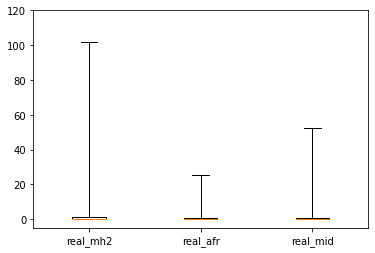

In [60]:
# Box and whisker plot of realistic pack prices
plt.boxplot([real_mh2_prices, real_afr_prices, real_mid_prices], whis=(0,100), labels=["real_mh2", "real_afr", "real_mid"])
plt.yticks(ticks=[0, 20, 40, 60, 80, 100, 120])
plt.show()

The price to buy a pack is, in order:
* 7.59 usd
* 2.97 usd
* 3.39 usd

Average selling price:
* 3.72 usd
* 0.69 usd
* 0.84 usd

For Modern Horizons 2, the average is nearly half the buying price of an unopened pack, and the maximum price has dropped to 100 usd. Now the other two sets have a huge gap for the worse between their average selling price and their pack cost.

## Real Case Prices

To quickly acquire a large amount of cards, buying a set case is the fastest option. A case is made up of 6 boxes, which are each made up of 36 packs, which are each made up of 15 cards, which are each made up of

Needless to say, it's a lot of cards, and a lot of potential selling value.

I'm defining a case as a dictionary where each key is the name of a card, and the value assigned to that key is a list of each card with that same name.

Since there's a total of 216 packs in 1 case, it will take 216,000 packs to make only 1000 cases. Instead of making new packs every time, we can use the packs we made earlier.

This next function will create 1000 cases, incrementally using the previously made packs.

In [61]:
# Generates 1000 cases from previously made packs
def make_case_list(set_packs):
    list_cases = []
    
    cases = []
    
    for i in range(0,216000,216):
        cases.append(set_packs[i:i+216])
        
    for packs in cases:
        case = {}
        for pack in packs:
            for card in pack:
                if card["name"] not in case:
                    # Makes the name of the card a key in the dictionary case
                    # Assigns the value to an empty list
                    case[card["name"]] = []
                    # Appends the card to that list
                    case[card["name"]].append(card)
                elif card["name"] in case:
                    case[card["name"]].append(card)

        list_cases.append(case)
        
    return list_cases

Pricing a case is different than a pack, because of the duplicate clause (I made that up).

Essentially, if you have 4 of the same card, you are more likely to sell all of them.

In [62]:
# Prices a given case realistically
def get_case_price(case):
    case_price = 0.0
    
    for name in case.keys():
        card_acumulated_price = 0.0
        for i, card in enumerate(case[name]):
            
            # Checks for foil
            card_price = float(card["usd"])
            if card["foil_bool"] == True and card["usd_foil"] != None:
                card_price = float(card["usd_foil"])
            
            # If number of cards is divisible by 4,
            # Ignore "sell percentage" reduction
            card_acumulated_price += card_price
            if (i + 1) % 4 == 0:
                case_price += card_acumulated_price
                card_acumulated_price = 0.0
        # Reduce the "sell percentage" of remainder cards
        if card_acumulated_price <= 4.00:
            case_price += card_acumulated_price/4
        elif card_acumulated_price <= 8.00:
            case_price += card_acumulated_price/2
        else:
            case_price += card_acumulated_price
    
    # 12.75% overhead when you sell 
    case_price = case_price - (case_price*0.1275)
    
    if case_price < 0.0:
        case_price = 0.0
        
    return case_price

In [63]:
# Prices any number of cases realistically
def price_set_cases(set_cases):
    set_cases_prices = []
    
    for case in set_cases:
        case_price = get_case_price(case)
    
        set_cases_prices.append(case_price)

    return set_cases_prices

Generating cases. . .

In [64]:
mh2_cases = make_case_list(mh2_packs)

In [65]:
afr_cases = make_case_list(afr_packs)

In [66]:
mid_cases = make_case_list(mid_packs)

Calculating prices. . .

In [67]:
mh2_case_prices = price_set_cases(mh2_cases)

In [68]:
afr_case_prices = price_set_cases(afr_cases)

In [69]:
mid_case_prices = price_set_cases(mid_cases)

In [77]:
print("Real average Mh2 case value: ", sum(mh2_case_prices) / len(mh2_case_prices))
print("Real average Afr case value: ", sum(afr_case_prices) / len(afr_case_prices))
print("Real average Mid case value: ", sum(mid_case_prices) / len(mid_case_prices))

Real average Mh2 case value:  1105.6047670937494
Real average Afr case value:  486.02839350000124
Real average Mid case value:  487.4239310750003


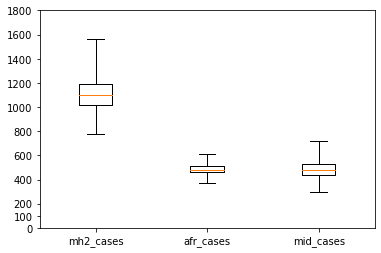

In [71]:
# Box and whisker plot of realistic case prices
plt.boxplot([mh2_case_prices, afr_case_prices, mid_case_prices], whis=(0, 100), labels=["mh2_cases", "afr_cases", "mid_cases"])
plt.yticks(ticks=[0, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800])
plt.show()

Cases are priced at:

* 1248 usd
* 610 usd
* 532 usd

And the average case sell prices are:

* 1246 usd
* 557 usd
* 714 usd

For Modern Horizons 2, the average is almost equal the buying price of an unopened case, and the maximum price is only 350 usd more than the average. Innistrad: Midnight Hunt's average is almost 200 usd more than its buying price.

This means an Innistrad: Midnight Hunt draft booster case will rake in the most profit. Between these three sets.

# Conclusion

In conclusion, Modern Horizons 2 cases are too hard to come by to resell, nobody's interested in Adventures In the Forgotten Realms along with very little price variability, and Innistrad: Midnight Hunt has a minimum sell price above the cost of purchasing the unopened case.

I'm sure there are many more factors that play into these calculations, but for now, the numbers show that Midnight Hunt is the best set to buy and resell for the sole purpose of making money.